In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
import tensorflow.keras as keras
import csv
import time

In [2]:
X = []
Y = []

with open('./data/data.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X.append(row[0])
        Y.append(int(row[1]))

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [4]:
def compute_descriptors(X):
    list_des = []
    list_kp = []
    kaze = cv2.KAZE_create()
    for x in X:
        img = cv2.imread(x, 0)
        img = cv2.resize(img, (128, 128))
        kp, des = kaze.detectAndCompute(img, None)
        list_des.append(des)
        list_kp.append(kp)
    return list_kp, list_des

In [13]:
def preparing(descriptors):

    res = []
    for item in descriptors:
        n_rows = item.shape[0]
        if n_rows < 128:
            arr = np.append(item[:128], np.zeros((128 - n_rows, 64)), axis=0)
        else:
            arr = item[:128]
        res.append(arr)

    return res

In [14]:
list_kp, list_des = compute_descriptors(X_train)
for i in range(len(list_des)):
    t = np.sum(list_des[i] == None)
    if t == 1:
        list_des[i] = np.zeros((64, 64))
print(np.mean([i.shape[0] for i in list_des]))

70.12865497076024


In [15]:
def get_key_point(list_kp, list_des):
    res = []
    for kp, des in zip(list_kp, list_des):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(des)
        labels = kmeans.labels_
        kp_array = np.array(kp)
        key = list(kp_array[labels == 1])
        res.append(key)
    return res

In [16]:
def get_points(list_kp):
    res = []
    for kp in list_kp:
        m = len(kp)
        points = np.zeros((m, 2))
        for i in np.arange(m):
            points[i] = np.array(kp[i].pt)

        res.append(points)

    return res

In [17]:
def get_train_date(list_kp, n=8):
    m = len(list_kp)
    X_train = np.zeros((m, n))
    kmeans = KMeans(n_clusters=n, random_state=0)
    for i in np.arange(m):
        if len(list_kp[i]) < n:
            X[i] = np.ones((1,n)) if len(list_kp[i]) != 0 else np.zeros((1,n))
        else:
            kmeans.fit(list_kp[i])
            histogram = np.histogram(kmeans.labels_, bins=n)
            X_train[i] = histogram[0] / np.sum(histogram[0])
    return X_train

In [8]:
key_points = get_key_point(list_kp, list_des)

<ipython-input-7-60e4fb186fc2>:4: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=2, random_state=0).fit(des)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 64

In [18]:
list_points = get_points(list_kp)
train = get_train_date(list_points, n=16)

In [11]:
def create_datsets (key_points):
    max_number_key_points = np.max([len(i) for i in key_points])
    n_sample = len(key_points)
    res = np.zeros((n_sample, max_number_key_points, 2))
    for i in range(n_sample):
        for j in range(len(key_points[i])):
            res[i,j] = np.array(key_points[i][j].pt)
    return res

In [194]:
train = create_datsets(key_points)
#train = preparing(list_des)

In [17]:
kaze = cv2.KAZE_create()
img = cv2.imread('./img/001.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.resize(img, (128, 128))
gray = cv2.resize(gray, (128, 128))
s = time.time()
kp, des = kaze.detectAndCompute(gray, None)
print(time.time() - s)

0.011351346969604492


In [41]:
class_id = [i.class_id for i in kp]
pt = [i.pt for i in kp]
my_pt = [(i.angle, i.size) for i in kp]

In [42]:
pt_arr = np.array(pt)

In [122]:
mask = np.array(class_id) == 1

In [43]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(pt_arr)
labels = kmeans.labels_
histogram = np.histogram(labels, bins=8)

In [60]:
kp_array = np.array(kp)
key = kp_array[labels == 7]
key = list(key)

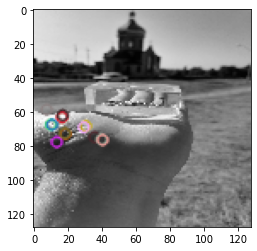

In [61]:
img_kp = cv2.drawKeypoints(gray, key, img)
plt.imshow(img_kp)

In [19]:
def model():
    key_points = keras.layers.Input(shape=(1,16), dtype='float32')
    X = keras.layers.BatchNormalization()(key_points)
    X = keras.layers.LSTM(128, return_sequences=False)(X)
    X = keras.layers.Dense(units=2)(X)
    X = keras.layers.Activation(activation='softmax')(X)

    model = keras.Model(inputs=key_points, outputs=X)

    return model

In [20]:
model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 16)]           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 16)             64        
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 74,562
Trainable params: 74,530
Non-trainable params: 32
_________________________________________________________________


In [21]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [198]:
X_train_ar = np.zeros((len(train), 128, 64))
Y_train_ar = np.zeros((len(train), 2))

for i in range(len(train)):
    X_train_ar[i] = train[i]
    Y_train_ar[i, Y[i]] = 1

ValueError: could not broadcast input array from shape (151,2) into shape (128,64)

In [22]:
X_train_ar = train[:, np.newaxis,:]
Y_train_ar = np.zeros((len(Y_train), 2))

for i in range(len(Y_train)):
    Y_train_ar[i, Y[i]] = 1

In [24]:
model.fit(X_train_ar, Y_train_ar, epochs=52, batch_size=64, shuffle=True)

Epoch 1/52
3/3 [==============================] - 0s 3ms/step - loss: 0.5711 - accuracy: 0.7018
Epoch 2/52
3/3 [==============================] - 0s 4ms/step - loss: 0.5651 - accuracy: 0.6901
Epoch 3/52
3/3 [==============================] - 0s 4ms/step - loss: 0.5613 - accuracy: 0.7018
Epoch 4/52
3/3 [==============================] - 0s 3ms/step - loss: 0.5670 - accuracy: 0.6842
Epoch 5/52
3/3 [==============================] - 0s 4ms/step - loss: 0.5619 - accuracy: 0.7076
Epoch 6/52
3/3 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.7018

In [16]:
def create_test(key_points, max_number_key_points):
    n_sample = len(key_points)
    res = np.zeros((n_sample, max_number_key_points, 2))
    for i in range(n_sample):
        for j in range(len(key_points[i])):
            res[i,j] = np.array(key_points[i][j].pt)
    return res

In [38]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

In [42]:
list_points_test = get_points(list_kp_test)
test = get_train_date(list_points_test, n=16)

In [43]:
X_test_ar = test[:,np.newaxis, :]

In [44]:
y_pred = model.predict(X_test_ar)
y_pred_target = np.argmax(y_pred, axis=1)
y_pred_probability = np.max(y_pred, axis=1)

In [45]:
y_target = np.array(Y_test)
recall = recall_score(y_target, y_pred_target)
precission = precision_score(y_target, y_pred_target)
f1 = f1_score(y_target, y_pred_target)

Y_test_ar = np.zeros((len(test), 2))
for i in range(len(test)):
    Y_test_ar[i, Y_test[i]] = 1
roc_auc = roc_auc_score(Y_test_ar, y_pred)

In [46]:
print(f'accuracy: {accuracy_score(y_target, y_pred_target)}')
print(f'recall: {recall}')
print(f'precission: {precission}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.4186046511627907
recall: 1.0
precission: 0.4186046511627907
f1: 0.5901639344262295
roc_auc: 0.5533333333333333


In [47]:
print(f'accuracy: {accuracy_score(y_target, y_pred_target)}')
print(f'confusion_matrix: \n{confusion_matrix(y_target, y_pred_target)}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.4186046511627907
confusion_matrix: 
[[ 0 25]
 [ 0 18]]
roc_auc: 0.5533333333333333


In [158]:
def compute_hist(frame, n=8):
    kaze = cv2.KAZE_create()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    kp, des = kaze.detectAndCompute(img, None)

    list_kp = np.array([i.pt for i in kp])
    kmeans = KMeans(n_clusters=n, random_state=0)
    X = np.zeros((1, n))
    if len(kp) < n:
        X[:] = np.ones((1,n)) if len(list_kp) != 0 else np.zeros((1,n))
    else:
        kmeans.fit(list_kp)
        histogram = np.histogram(kmeans.labels_, bins=n)
        X[:] = histogram[0] / np.sum(histogram[0])
    return X

In [161]:
cap = cv2.VideoCapture('test.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False):
  print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
  ret, frame = cap.read()

  if ret == True:
    X = compute_hist(frame)[np.newaxis, :, :]
    class_object = np.argmax(model.predict(X))
    position = (25, 350)
    cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 8, (209, 80, 0, 255), 3)
    out.write(frame)

  else:
    break

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
## X_train



In [48]:
y_pred = model.predict(X_train_ar)
y_pred_tar = np.argmax(y_pred, axis=1)

In [49]:
y_target = np.array(Y_train)
recall = recall_score(y_target, y_pred_tar)
precission = precision_score(y_target, y_pred_tar)
f1 = f1_score(y_target, y_pred_tar)
#roc_auc = roc_auc_score(y_target, y_pred)

In [50]:
print(f'recall: {recall}')
print(f'precission: {precission}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

recall: 0.9753086419753086
precission: 0.4817073170731707
f1: 0.6448979591836734
roc_auc: 0.5533333333333333


In [51]:
print(f'con_mat: {confusion_matrix(y_target, y_pred_tar)}')

con_mat: [[ 5 85]
 [ 2 79]]


In [21]:
'''
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')
'''

## SVM Linear

In [64]:
linear_SVM = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, C=10**6)
scaler = StandardScaler()
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
linear_SVM.fit(X_train_arr, Y_train_arr)

LinearSVC(C=1000000, dual=False)

In [65]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test, n=16))

In [66]:
y_pred = linear_SVM.predict(test)

In [67]:
y_target = np.array(Y_test)

In [68]:
accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [69]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.5348837209302325
confusion matrix: 
 [[16  9]
 [11  7]]


## SVC

In [59]:
svc = SVC(kernel='sigmoid', coef0=10**-6, C=10**6, gamma='auto')
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
svc.fit(X_train_arr, Y_train_arr)

SVC(C=1000000, coef0=1e-06, gamma='auto', kernel='sigmoid')

In [60]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test, n=16))

In [61]:
y_pred = svc.predict(test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [62]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.6046511627906976
confusion matrix: 
 [[19  6]
 [11  7]]


In [63]:
y_pred = svc.predict(train)

y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.5263157894736842
confusion matrix: 
 [[90  0]
 [81  0]]


## NuSVC

In [176]:
nusvc = NuSVC(nu=0.5, kernel='sigmoid', coef0=10**-6)
X_train_arr = scaler.fit_transform(train)
Y_train_arr = np.array(Y_train)
nusvc.fit(X_train_arr, Y_train_arr)

NuSVC(coef0=1e-06, kernel='sigmoid')

In [177]:
list_kp_test, list_des_test = compute_descriptors(X_test)
for i in range(len(list_des_test)):
    t = np.sum(list_des_test[i] == None)
    if t == 1:
        list_des_test[i] = np.zeros((64, 64))

list_points_test = get_points(list_kp_test)
test = scaler.transform(get_train_date(list_points_test))

In [178]:
y_pred = nusvc.predict(test)
y_target = np.array(Y_test)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

In [179]:
print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.27450980392156865
confusion matrix: 
 [[ 7  7  1]
 [ 6  4  4]
 [14  5  3]]


In [180]:
y_pred = nusvc.predict(train)

y_target = np.array(Y_train)

accuracy = accuracy_score(y_target, y_pred)
conf_matrix = confusion_matrix(y_target, y_pred)

print(f'accuracy: {accuracy}')
print(f'confusion matrix: \n {conf_matrix}')

accuracy: 0.16336633663366337
confusion matrix: 
 [[25  6  0]
 [77  8  0]
 [76 10  0]]
